In [1]:
import random


def get_vocab():
    node_numbers = '0123456789'
    node_lowers = 'qwertyuiopasdfghjklzxcvbnm'
    node_upper = 'QWERTYUIOPASDFGHJKLZXCVBNM'

    node = node_numbers + node_lowers + node_upper + '$'

    edge = []
    for i in range(100):
        n1 = random.choice(node_numbers)
        n2 = random.choice(node_numbers)
        edge.append((n1, n2))

    for i in range(100):
        n1 = random.choice(node_lowers)
        n2 = random.choice(node_lowers)
        edge.append((n1, n2))

    for i in range(200):
        n1 = random.choice(node_upper)
        n2 = random.choice(node_upper)
        edge.append((n1, n2))

    for i in range(50):
        n1 = random.choice(node)
        n2 = random.choice(node)
        edge.append((n1, n2))

    random.shuffle(edge)

    #编码
    node = {name: i for i, name in enumerate(node)}
    edge = [(node[i[0]], node[i[1]]) for i in edge]

    return node, edge


node, edge = get_vocab()

print(node)
print(edge)

{'0': 0, '1': 1, '2': 2, '3': 3, '4': 4, '5': 5, '6': 6, '7': 7, '8': 8, '9': 9, 'q': 10, 'w': 11, 'e': 12, 'r': 13, 't': 14, 'y': 15, 'u': 16, 'i': 17, 'o': 18, 'p': 19, 'a': 20, 's': 21, 'd': 22, 'f': 23, 'g': 24, 'h': 25, 'j': 26, 'k': 27, 'l': 28, 'z': 29, 'x': 30, 'c': 31, 'v': 32, 'b': 33, 'n': 34, 'm': 35, 'Q': 36, 'W': 37, 'E': 38, 'R': 39, 'T': 40, 'Y': 41, 'U': 42, 'I': 43, 'O': 44, 'P': 45, 'A': 46, 'S': 47, 'D': 48, 'F': 49, 'G': 50, 'H': 51, 'J': 52, 'K': 53, 'L': 54, 'Z': 55, 'X': 56, 'C': 57, 'V': 58, 'B': 59, 'N': 60, 'M': 61, '$': 62}
[(41, 47), (27, 10), (33, 32), (35, 30), (15, 28), (54, 47), (47, 57), (38, 48), (0, 5), (44, 46), (18, 10), (48, 36), (24, 16), (48, 50), (6, 6), (49, 60), (33, 25), (6, 2), (23, 15), (5, 8), (26, 21), (52, 49), (26, 16), (19, 20), (6, 2), (43, 58), (1, 9), (36, 42), (16, 29), (46, 57), (9, 5), (36, 49), (55, 44), (42, 44), (18, 35), (42, 50), (54, 60), (57, 42), (18, 17), (23, 31), (35, 21), (45, 59), (39, 55), (19, 25), (1, 1), (8, 7),

In [2]:
import torch


def get_batch():
    sample = random.sample(edge, 4)

    pos = []
    neg = []
    for i in sample:
        n1, n2 = i
        while (n1, n2) in edge:
            n1 = random.randint(0, len(node) - 1)
        neg.append((n1, n2))

        n1, n2 = i
        while (n1, n2) in edge:
            n2 = random.randint(0, len(node) - 1)
        neg.append((n1, n2))

        pos.append(i)
        pos.append(i)

    pos = torch.LongTensor(pos)
    neg = torch.LongTensor(neg)

    return pos, neg


get_batch()

(tensor([[31, 23],
         [31, 23],
         [11, 61],
         [11, 61],
         [25, 14],
         [25, 14],
         [27, 28],
         [27, 28]]),
 tensor([[ 4, 23],
         [31, 20],
         [ 8, 61],
         [11, 47],
         [30, 14],
         [25, 49],
         [36, 28],
         [27, 45]]))

In [3]:
def get_cos_loss(pos, neg):
    #pos -> [8, 2, 2]
    #neg -> [8, 2, 2]

    #[8, 1, 2]
    pos_n1 = pos[:, 0].unsqueeze(dim=1)
    #[8, 2, 1]
    pos_n2 = pos[:, 1].unsqueeze(dim=2)

    #[8, 1, 2],[8, 2, 1] -> [8]
    loss_pos = torch.bmm(pos_n1, pos_n2).squeeze()

    #[8, 1, 2]
    neg_n1 = neg[:, 0].unsqueeze(dim=1)
    #[8, 2, 1]
    neg_n2 = neg[:, 1].unsqueeze(dim=2)

    #[8, 1, 2],[8, 2, 1] -> [8]
    loss_neg = torch.bmm(neg_n1, -neg_n2).squeeze()

    #[8, 2] -> [8]
    loss_pos = loss_pos.sigmoid().log()

    #[8, 2] -> [8]
    loss_neg = loss_neg.sigmoid().log()

    return -(loss_pos + loss_neg).mean()


a, b = torch.randn(8, 2, 2), torch.randn(8, 2, 2)
get_cos_loss(a, b)

tensor(2.3560)

In [4]:
class Model(torch.nn.Module):

    def __init__(self):
        super().__init__()

        #V是词汇量
        self.embed = torch.nn.Embedding(num_embeddings=len(node),
                                        embedding_dim=2)

        #初始化参数
        self.embed.weight.data.uniform_(-0.01, 0.01)

    def forward(self, pos, neg):
        #编码
        #[8, 6] -> [8, 6, 2]
        pos = self.embed(pos)

        #[8, 12] -> [8, 12, 2]
        neg = self.embed(neg)

        return get_cos_loss(pos, neg)


model = Model()

model(*get_batch())

tensor(1.3863, grad_fn=<NegBackward0>)

In [5]:
def test(test_words):
    embed = model.embed.weight.data.clone()

    for word in test_words:
        x = embed[node[word]]
        score = torch.nn.functional.cosine_similarity(x, embed)
        topk = score.topk(k=5).indices
        topk = [list(node.keys())[k] for k in topk]
        print(word, topk)


test(['a', 'g', '1', '5', 'Q', 'H'])

a ['a', '$', 'z', 'o', 'W']
g ['g', 'j', 'F', 'b', 'r']
1 ['1', 'Q', 'X', 'M', 'D']
5 ['5', '3', 'E', 'R', 'm']
Q ['Q', 'X', '1', 'M', 'D']
H ['H', 'w', '9', 'p', 'U']


In [6]:
def train():
    global model
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    model = model.to(device)

    model.train()
    optimizer = torch.optim.Adam(model.parameters(), lr=2e-3)
    loss_sum = 0
    for epoch in range(20001):
        batch = get_batch()
        batch = [i.to(device) for i in batch]

        loss = model(*batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        loss_sum += loss.item()

        if epoch % 5000 == 0:
            print(epoch, loss_sum)
            test(['a', 'g', '1', '5', 'Q', 'H'])
            loss_sum = 0

    model = model.cpu()


train()

0 1.3863022327423096
a ['a', 'r', '$', 'z', 'o']
g ['g', 'j', 'F', 'b', 'B']
1 ['1', 'N', 'K', 'Q', 'V']
5 ['5', '3', 'E', 'S', 'm']
Q ['Q', 'X', 'D', 'i', 'w']
H ['H', '9', 'p', 'v', 'U']
5000 5349.830901950598
a ['a', 'd', 'c', 'p', 'u']
g ['g', 'i', 'h', 'j', 'n']
1 ['1', '7', '8', '0', '5']
5 ['5', '8', '1', '9', '7']
Q ['Q', 'A', 'M', 'R', 'L']
H ['H', 'F', 'Y', 'B', 'E']
10000 4710.985986799002
a ['a', 'u', 'e', 'c', 'p']
g ['g', 'd', 'v', 'j', 'h']
1 ['1', '5', '8', '3', '9']
5 ['5', '8', '1', '3', '9']
Q ['Q', 'W', 'A', 'Z', 'R']
H ['H', 'B', 'Y', 'F', 'X']
15000 4709.044643640518
a ['a', 'u', 'c', 'e', 'p']
g ['g', 'j', '$', 'i', 's']
1 ['1', '8', '5', '3', '4']
5 ['5', '1', '8', '3', '4']
Q ['Q', 'Z', 'W', 'L', 'P']
H ['H', 'Y', 'B', 'X', 'F']
20000 4671.361401081085
a ['a', 'c', 'u', 'e', 'p']
g ['g', 'w', 'n', 'j', '$']
1 ['1', '8', '5', '7', '4']
5 ['5', '8', '1', '7', '4']
Q ['Q', 'W', 'A', 'M', 'Z']
H ['H', 'Y', 'B', 'X', 'F']


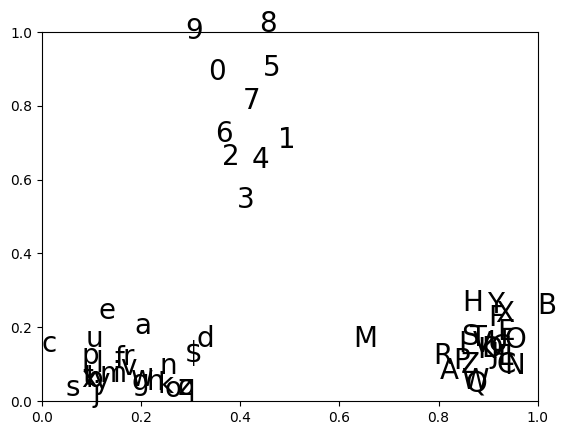

In [7]:
from matplotlib import pyplot as plt
%matplotlib inline


def show():

    #缩放到0-1空间
    embed = model.embed.weight.data.clone()
    embed -= embed.min(dim=0).values
    embed /= embed.max(dim=0).values

    for word, x in node.items():
        x = embed[x]
        plt.text(x[0], x[1], word, fontsize=20)

    plt.show()


show()